In [ ]:
import pandas as pd

data  = pd.read_csv('/content/deforestation_sentiment_train.csv', usecols=["text","distillbert_valence"])
num_classes = 2
data

In [ ]:

from gensim.parsing.preprocessing import remove_stopwords

import re
def process_sentence(sentence):
    '''Removes all special characters from sentence. It will also strip out
    extra whitespace and makes the string lowercase.
    '''

    return re.sub(r'[@#\\\\/:*«`\'?¿";!<>,.|_]+', '', sentence.lower().strip())

def smallwords_remover(tweet):
  #remove all stop words
    return remove_stopwords(tweet)



def sentiment_converter(neg_pos_sent):
  if (neg_pos_sent < 0):
    return "0"
  else:
    return "1"

# Clean the sentences
X = data["text"].apply(process_sentence).apply(smallwords_remover)[:500]
y = data["distillbert_valence"].apply(sentiment_converter)[:500]

labels  = set(y)

print(X)

In [ ]:
#word cloud visualisation
text = data['text'].values

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)

print(len(x_train), len(x_test))

len(x_train), len(x_test)
labels = set(y)

#split all our sentences

elements = (' '.join([sentence for sentence in X])).split()
print("Feature Shapes:")
print("\tTrain set: \t\t{}".format(x_train.shape),
      "\n\tTest set: \t\t{}".format(x_test.shape))
print("Totals:\n\tWords in our Dataset: {}\n\tLabels: {}".format(len(elements), len(labels)))

In [ ]:
#lets look at our training data
print(x_train[:10], y_train[:10])

In [ ]:
# Look up table, encoding vocab to numbers and numbers back to vocab

def create_lookup_tables(text):
    """Create lookup tables for vocabulary
    :param text: The text split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab = set(text)

    vocab_to_int = {word: i for i, word in enumerate(vocab)}
    int_to_vocab = {v:k for k, v in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab

elements.append("<UNK>")

    # Map our vocab to int
vocab_to_int, int_to_vocab = create_lookup_tables(elements)
labels_to_int, int_to_labels = create_lookup_tables(y)

print("Vocabulary of our dataset: {}".format(len(vocab_to_int)))

Vocabulary of our dataset: 4836


In [ ]:
def convert_to_int(data, data_int):
    """Converts all our text to integers
    :param data: The text to be converted
    :return: All sentences in ints
    """
    all_items = []
    for sentence in data:
        all_items.append([data_int[word] if word in data_int else data_int["<UNK>"] for word in sentence.split()])

    return all_items

In [ ]:
     # Convert our inputs
X_test_encoded = convert_to_int(x_test, vocab_to_int)
X_train_encoded = convert_to_int(x_train, vocab_to_int)

In [ ]:
y_data = convert_to_int(y_test, labels_to_int)

In [ ]:

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_data)

OneHotEncoder()

In [ ]:
# One hot encoding our outputs
y_train_encoded = enc.fit_transform(convert_to_int(y_train, labels_to_int)).toarray()
y_test_encoded = enc.fit_transform(convert_to_int(y_test, labels_to_int)).toarray()

# Sample of our encoding
print(y_train_encoded[:10],'\n', y_train[:10])

In [ ]:
#Downloading pre trained Glove embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
path_to_glove_file = "/content/glove.6B.100d.txt"

In [ ]:
import numpy as np

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep= " ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(set(elements)) + 2

embedding_dim = 100
hits = 0
misses = 0

Found 400000 word vectors.


In [ ]:
#Prepare embedding matrix

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocab_to_int.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    #Words not found in embedding index will be all zeros
    #This includes the representation for "padding" and Out of vocabulary
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2918 words (1918 misses)


In [ ]:
import tensorflow as tf

# Import Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Embedding
from keras.preprocessing import sequence

# Hyperparameters
max_sentence_length = 200
embedding_vector_length = 300
dropout = 0.5

In [ ]:
# Truncate and pad input sentences
X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_encoded, maxlen=max_sentence_length)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_encoded, maxlen=max_sentence_length)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         483800    
                                                                 
 gru_16 (GRU)                (None, None, 256)         274944    
                                                                 
 gru_17 (GRU)                (None, 256)               394752    
                                                                 
 dense_8 (Dense)             (None, 2)                 514       
                                                                 
Total params: 1,154,010
Trainable params: 1,154,010
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
13/13 [==============================] - 36s 2s/step - loss: 0.5541 - accuracy: 0.7575 - val_loss: 0.5524 - val_accuracy: 0.7500
Epoch 2/10
13/13 [=============

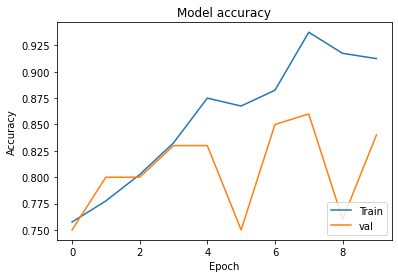

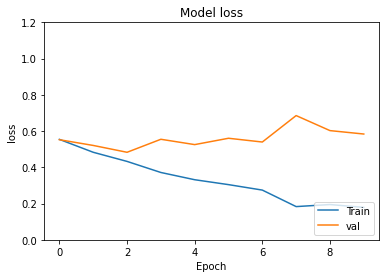

In [ ]:
# Create the model
model = Sequential()

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

model.add(embedding_layer)
model.add(GRU(256, return_sequences=True, dropout=dropout, recurrent_dropout=dropout))
model.add(GRU(256, dropout=dropout, recurrent_dropout=dropout))
model.add(Dense(len(labels), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
hist = model.fit(X_train_pad, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test_encoded))

# Final evaluation of the model
scores = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc = 'lower right')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc = 'lower right')
plt.ylim(top=1.2, bottom=0)
plt.show()

def predict_sentence(sentence):
    """Converts the text and sends it to the model for classification
    :param sentence: The text to predict
    :return: string - The label of the sentence
    """

    # Clean the sentence
    sentence = process_sentence(sentence)

    # Transform and pad it before using the model to predict
    x = numpy.array(convert_to_int([sentence], vocab_to_int))
    x = sequence.pad_sequences(x, maxlen=max_sentence_length)

    prediction = model.predict(x)

    # Get the highest prediction
    lang_index = numpy.argmax(prediction)

    return int_to_labels[lang_index]